<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5440_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 68s 162ms/step - loss: 0.0417 - val_loss: 0.0287
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 64s 163ms/step - loss: 0.0281 - val_loss: 0.0259
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 84s 167ms/step - loss: 0.0260 - val_loss: 0.0252
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 75s 149ms/step - loss: 0.0252 - val_loss: 0.0248
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 58s 149ms/step - loss: 0.0247 - val_loss: 0.0244
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 84s 154ms/step - loss: 0.0242 - val_loss: 0.0240
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 84s 160ms/step - loss: 0.0238 - val_loss: 0.0235
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 171ms/step - loss: 0.0236 - val_loss: 0.0235
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 61s 155ms/step - loss: 0.0233 - val_loss: 0.0231
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 58s 149ms/step - loss: 0.0231

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


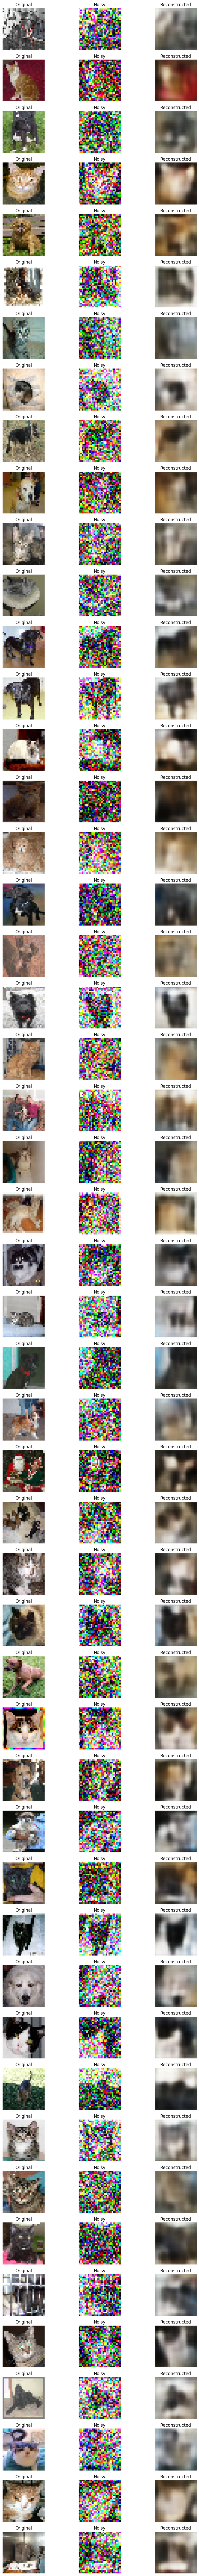

In [9]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive
drive.mount('/content/drive')

# Set dataset paths
train_dir = "/content/drive/My Drive/train/"
test_dir = "/content/drive/My Drive/test1/"

# Function to load and preprocess images
def load_images(directory, size=(28, 28)):
    images = []
    filenames = os.listdir(directory)
    for file in filenames:
        img = load_img(os.path.join(directory, file), target_size=size)
        img = img_to_array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

# Load and preprocess images
x_train = load_images(train_dir)
x_test = load_images(test_dir)

# Reshape for model compatibility
x_train = np.reshape(x_train, (len(x_train), 28, 28, 3))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 3))

# Add noise to training data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Define the autoencoder model
input_img = Input(shape=(28, 28, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Compile model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train model
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# Save model
autoencoder.save("/content/drive/My Drive/image_upscaler.h5")

# Load trained model and visualize output
num_images = 50
test_samples = x_test_noisy[:num_images]
reconstructed = autoencoder.predict(test_samples)

fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 2))
for i in range(num_images):
    axes[i, 0].imshow(x_test[i])
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(test_samples[i])
    axes[i, 1].set_title("Noisy")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(reconstructed[i])
    axes[i, 2].set_title("Reconstructed")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()